In [1]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import re
from nltk.corpus import stopwords

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path 
stop_words = set(stopwords.words('english'))

unable to import 'smart_open.gcs', disabling that module


In [100]:
df = pd.read_csv("/Users/shiyipeng/Downloads/myanimelist-comment-dataset/animeReviewsOrderByTime.csv",error_bad_lines=False)

In [3]:
df = pd.DataFrame(df)

In [12]:
df.columns

Index(['id', 'workId', 'reviewId', 'workName', 'postTime', 'episodesSeen',
       'author', 'peopleFoundUseful', 'overallRating', 'storyRating',
       'animationRating', 'soundRating', 'characterRating', 'enjoymentRating',
       'review'],
      dtype='object')

In [4]:
nRowsRead = 'None' # specify 'None' if want to read whole file
# animeReviewsOrderByTime.csv has 135201 rows in reality, but we are only loading/previewing the first 1000 rows

with open('/Users/shiyipeng/Downloads/myanimelist-comment-dataset/animeReviewsOrderByTime.csv', 'r', encoding='utf-8') as f:
    headers = f.readline().replace('"','').replace('\n','').split(',')
    print(headers)
    print('The number of column: ', len(headers))
    dataFormat = dict()
    for header in headers:
        dataFormat[header] = list()

    for idx, line in enumerate(tqdm(f.readlines(), desc='Now parsing... ')):
        
        if idx == 67:
            yee = line
        
        if line != '':
            line = line.replace('\n','')
            indices = [i for i, x in enumerate(line) if x == ',']
            idxStart = 0
            for i in range(len(headers)):
                if i < len(headers) - 1:
                    dataFormat[headers[i]].append(line[idxStart + 1:indices[i] - 1])
                    idxStart = indices[i] + 1
                elif i == len(headers) - 1:
                    dataFormat[headers[i]].append(line[idxStart + 1:-1])
                else:
                    break
        if nRowsRead is not None and nRowsRead == idx + 1:
            print('We read only', nRowsRead, 'lines.')
            break

['id', 'workId', 'reviewId', 'workName', 'postTime', 'episodesSeen', 'author', 'peopleFoundUseful', 'overallRating', 'storyRating', 'animationRating', 'soundRating', 'characterRating', 'enjoymentRating', 'review']
The number of column:  15


In [67]:
review_df = pd.DataFrame(dataFormat)
review_df = review_df.iloc[0:15000,:]

In [68]:
review_df.head()

,id,workId,reviewId,workName,postTime,episodesSeen,author,peopleFoundUseful,overallRating,storyRating,animationRating,soundRating,characterRating,enjoymentRating,review
0,8121,1,1,Cowboy_Bebop,2006-11-07 18:34:00,26,Xinil,162,10,8,10,10,10,10,Cowboy Bebop is an episodic series. By episodi...
1,63480,856,9,Utawarerumono,2006-11-08 00:24:00,26,Crystal,218,8,8,7,7,9,8,Utawarerumono manages to be one of those harem...
2,8452,263,10,Hajime_no_Ippo,2006-11-08 14:39:00,76,Xinil,827,10,10,9,9,10,10,"First, let me say that I\\'m not a fan of boxi..."
3,66544,129,11,Gensoumaden_Saiyuuki,2006-11-09 05:22:00,50,Chelle,69,9,8,6,7,10,9,Saiyuki is one of those animes that just grabs...
4,55936,210,12,Ranma_½,2006-11-09 16:48:00,161,running_lemon,40,7,6,8,8,8,7,A comedy/romance based on the manga by Rumiko ...


In [459]:
review_df.to_csv("reviewCSV.csv")

In [29]:
print(len(review_df))

5000


In [81]:
 review_df['tokenized_sents'] = review_df['review'].apply(lambda x:[lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x) if s not in stop_words ])

In [82]:
review_df['normalized_sents'] = review_df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [13]:
review_df[:100:10]

,id,workId,reviewId,workName,postTime,episodesSeen,author,peopleFoundUseful,overallRating,storyRating,animationRating,soundRating,characterRating,enjoymentRating,review,tokenized_sents,normalized_sents
0,8121,1,1,Cowboy_Bebop,2006-11-07 18:34:00,26,Xinil,162,10,8,10,10,10,10,Cowboy Bebop is an episodic series. By episodi...,"[[Cowboy, Bebop, is, an, episodic, series], [B...","[[cowboy, bebop, episodic, series], [episodic,..."
10,101808,751,18,Bomberman_Jetters,2006-11-13 15:44:00,52,AngelIvory,11,9,9,9,7,7,9,"Bomberman, if you liked the game then you will...","[[Bomberman, if, you, liked, the, game, then, ...","[[bomberman, liked, game, like, anime], [think..."
20,116762,133,30,Green_Green,2006-11-24 09:45:00,12,martino,150,8,6,8,9,8,8,===Animation===Quite nice and steady animation...,"[[=, =, =, Animation===Quite], [nice, and, ste...","[[=, =, =, animation===quite], [nice, steady, ..."
30,27052,853,40,Ouran_Koukou_Host_Club,2006-12-24 09:54:00,26,Xinil,174,8,8,9,8,10,9,Looking for a show to laugh your ass off? Look...,"[[Looking, for, a, show, to, laugh, your, ass,...","[[looking, laugh, ass], [look, ouran, high, sc..."
40,53443,317,56,Final_Fantasy_VII__Advent_Children,2007-01-08 00:02:00,1,Ceray,101,9,8,10,9,9,9,There aren't many video game players that I kn...,"[[There, are, n't, many, video, game, players,...","[[video, game, players, know, heard, final, fa..."
50,46396,85,75,Mobile_Suit_Zeta_Gundam,2007-01-21 14:33:00,50,OtakuFreak,20,10,10,8,9,10,8,After I became addicted to the Gundam universe...,"[[After, I, became, addicted, to, the, Gundam,...","[[addicted, gundam, universe, series, dying, m..."
60,53465,317,90,Final_Fantasy_VII__Advent_Children,2007-01-25 20:57:00,1,ivorykeys,7,10,10,10,10,9,10,FFVII Advent Children....WOW! What a fantastic...,"[[FFVII, Advent, Children], [WOW], [What, a, f...","[[ffvii, advent, children], [wow], [fantastic,..."
70,60854,87,109,Mobile_Suit_Gundam__Chars_Counterattack,2007-02-01 15:08:00,1,OtakuFreak,22,9,9,10,9,10,9,Another of the UC Gundam seires is in review. ...,"[[Another, of, the, UC, Gundam, seires, is, in...","[[uc, gundam, seires, review], [introduced, gu..."
80,102434,1568,123,Sumomomo_Momomo__Chijou_Saikyou_no_Yome,2007-02-05 17:23:00,,bettynoire,72,9,8,7,8,10,10,The thing about Sumomo mo Momo mo is that for ...,"[[The, thing, about, Sumomo, mo, Momo, mo, is,...","[[thing, sumomo, mo, momo, mo, episodes, convi..."
90,90100,390,135,Suzuka,2007-02-07 21:48:00,26,rusette,182,8,8,8,8,9,7,I have to say after seeing the whole series ev...,"[[I, have, to, say, after, seeing, the, whole,...","[[seeing, series, lot, people, said, sucked], ..."


In [14]:
reviewW2V = gensim.models.word2vec.Word2Vec(review_df['normalized_sents'].sum())
reviewW2V['people']

array([ 1.1038873 , -0.176359  ,  0.3480285 ,  0.29849905,  0.6096195 ,
        1.1159438 , -0.21845603, -0.31832272, -1.3199272 , -0.92404616,
        1.0668259 ,  1.5050788 , -0.39584342, -0.59719455, -1.3599824 ,
        1.5373003 , -2.2474892 , -0.7090683 ,  0.80336237, -0.24457563,
       -0.427895  , -0.9251555 ,  1.259764  , -0.6768172 , -1.3625624 ,
        0.61188287,  0.12880976,  0.95788676, -0.30775493, -1.1211289 ,
       -0.20990275,  1.0304292 , -0.50764084, -0.6213444 ,  0.1859648 ,
        1.1970522 ,  0.36244866,  1.5232556 ,  1.1139876 , -0.34309202,
       -0.05658117,  0.2594782 ,  0.9109661 ,  0.893326  ,  1.5016395 ,
        0.9016543 , -0.32180706, -1.0528514 , -0.260168  , -0.6107211 ,
        0.46237415, -0.38485023, -2.004648  ,  0.7382373 ,  1.0755956 ,
        0.42119437,  0.8266001 , -1.4009106 ,  0.24803291, -0.3476314 ,
        0.26477072, -0.21505556, -0.965719  ,  0.595706  , -1.4477642 ,
       -0.34339258,  1.6323596 , -0.20824228, -0.7189581 ,  1.25

In [469]:
reviewW2V_sg = gensim.models.word2vec.Word2Vec(review_df['normalized_sents'].sum(),sg=0)

In [473]:
reviewW2V_sg.wv.syn0

array([[ 0.12814385, -0.65448374,  0.26498452, ..., -0.6477126 ,
        -0.8901765 ,  0.5011775 ],
       [ 0.04619661, -0.20310569, -0.3687164 , ..., -0.6346404 ,
        -0.2807196 ,  0.72473663],
       [ 0.3581876 , -1.0563473 ,  0.60413474, ...,  0.5866377 ,
        -0.32497555, -0.13061444],
       ...,
       [ 0.12456775, -0.02896465,  0.02687157, ..., -0.05805482,
        -0.00267247, -0.00715161],
       [ 0.07098372, -0.01541638,  0.01765821, ..., -0.01761384,
        -0.02232168,  0.01328673],
       [ 0.10004701, -0.00419356,  0.03140612, ..., -0.00708884,
         0.00164382, -0.02742243]], dtype=float32)

In [475]:
reviewW2V_sg.doesnt_match(
['cowboy', 'crush', 'magical',
 'tale', 'adventure'])

'cowboy'

In [650]:
reviewW2V_sg.doesnt_match(
['cowboy','crush','magical',
'tale','adventrue'])

'cowboy'

In [478]:
def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [496]:
review_df['normalized_words']
words = []
for each in review_df['normalized_words']:
    for i in each:
        if "\\" in i:
            continue
        if i.isdigit() == False:
            words.append(i)
words

['cowboy',
 'bebop',
 'episodic',
 'series',
 'episodic',
 'mean',
 'episode',
 'necessarily',
 'lead',
 'follow',
 'said',
 'expect',
 'lot',
 'series',
 'watch',
 'cowboy',
 'bebop',
 'characters',
 'plain',
 'simple',
 'spike',
 'faye',
 'jet',
 'ed',
 'ein',
 'anime',
 'arguably',
 'memorable',
 'series',
 'produced',
 'music',
 'awesome',
 'especially',
 'fan',
 'jazz',
 'animation',
 'notch',
 'considering',
 'series',
 'came',
 'enjoyment',
 'value',
 'second',
 'lot',
 'people',
 'want',
 'feel',
 'kind',
 'person',
 'enjoys',
 'fast',
 'paced',
 'anime',
 'character',
 'getting',
 'spotlight',
 'type',
 'enjoy',
 'fast',
 'paced',
 'bounty',
 'huntin',
 'fun',
 'like',
 'deep',
 'thought',
 'provoking',
 'dark',
 'mysterious',
 'shows',
 'watch',
 'cowboy',
 'bebop',
 'vicious',
 'characters',
 'able',
 'bring',
 'little',
 'sinister',
 'kind',
 'utawarerumono',
 'manages',
 'harem',
 'animes',
 'possibly',
 'find',
 'enjoyable',
 'particularly',
 'like',
 'concept',
 'harems'

In [39]:
reviewW2V.wv.syn0

array([[ 0.05951188, -0.7388488 ,  0.13702476, ..., -0.84931046,
        -0.8986795 ,  0.3230357 ],
       [ 0.1385944 , -0.08336248, -0.92674345, ...,  0.24038537,
        -0.18178526,  0.51117885],
       [ 0.32035998, -0.99359226,  0.01297696, ...,  1.014285  ,
        -0.07044256, -0.15711258],
       ...,
       [ 0.10281115, -0.03042682,  0.01618071, ..., -0.01561393,
        -0.00696898, -0.0079455 ],
       [ 0.05661745, -0.01016468,  0.00859534, ..., -0.00875099,
        -0.01729053,  0.01221136],
       [ 0.0942239 , -0.01194219,  0.01671214, ...,  0.00335156,
        -0.00358949, -0.01978069]], dtype=float32)

In [400]:
reviewW2V.wv.index2word[100]

'shows'

In [401]:
reviewW2V.most_similar('horror')

[('screwball', 0.966116189956665),
 ('thriller', 0.9516334533691406),
 ('pure', 0.94920414686203),
 ('genres', 0.9455623030662537),
 ('enjoys', 0.9415861964225769),
 ('junkie', 0.937781572341919),
 ('slapstick', 0.9358917474746704),
 ('adventure', 0.9326483607292175),
 ('comedies', 0.9308334589004517),
 ('romp', 0.924423098564148)]

In [63]:
reviewW2V.most_similar('best')

[('worst', 0.8400263786315918),
 ('greatest', 0.8346506357192993),
 ('favourite', 0.7971599698066711),
 ('unlike', 0.7890238761901855),
 ('saddest', 0.7611674070358276),
 ('i&rsquo;ve', 0.7509399652481079),
 ('funniest', 0.7505335807800293),
 ("i\\\\'ve", 0.7461510896682739),
 ('favorite', 0.7419319152832031),
 ('loved', 0.7309887409210205)]

In [467]:
reviewW2V.most_similar('orchestra')

[('acoustic', 0.9848574995994568),
 ('accompanied', 0.9838211536407471),
 ('vocals', 0.9829440116882324),
 ('instruments', 0.9817919135093689),
 ('melodies', 0.9816027879714966),
 ('soothing', 0.9815669059753418),
 ('evocative', 0.9811508655548096),
 ('orchestral', 0.9798853397369385),
 ('haunting', 0.9791637659072876),
 ('techno', 0.9784820079803467)]

In [468]:
reviewW2V.similarity('orchestra','cowboy')

0.5780048

In [464]:
reviewW2V.doesnt_match(
['cowboy', 'crush', 'magical',
 'tale', 'adventure'])

'cowboy'

In [170]:
reviewW2V.most_similar(positive=
['monster', 'giant'], negative = ['scary'])

[('robot', 0.9033343195915222),
 ('space', 0.8789113163948059),
 ('war', 0.8712047934532166),
 ('humans', 0.8617904186248779),
 ('monsters', 0.8595252633094788),
 ('power', 0.8590700626373291),
 ('living', 0.8576363325119019),
 ('earth', 0.857327401638031),
 ('tale', 0.8558833003044128),
 ('secret', 0.853628396987915)]

In [67]:
reviewW2V.save("reviewWORD2Vec")

In [15]:
numWords = 100
targetWords = reviewW2V.wv.index2word[:numWords]

In [16]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(reviewW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.65470284,  0.5613238 ,  0.58732736, ..., -1.4957318 ,
        -0.31469083,  0.885352  ],
       [-1.3246515 ,  0.07514439,  1.0957496 , ..., -0.5812275 ,
        -0.5448955 ,  0.8602921 ],
       [ 0.43063927, -0.79568386,  1.533702  , ...,  1.2064046 ,
        -2.2701466 ,  1.7276573 ],
       ...,
       [-0.18360838,  0.81327796,  0.02060139, ..., -0.22958823,
        -1.8506157 ,  0.86790776],
       [-0.15451837, -0.3880261 , -1.0316975 , ..., -0.04803879,
         1.1737674 ,  0.35441542],
       [ 0.5380852 ,  0.99457914, -0.91829205, ...,  0.8112428 ,
         0.56488836,  0.53658533]], dtype=float32)

In [17]:
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#print(reducedPCA_data)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(wordsSubMatrix)
#print(tsneWords)
print(pcaWords.explained_variance_/np.sum(pcaWords.explained_variance_))


[0.50686204 0.49313796]


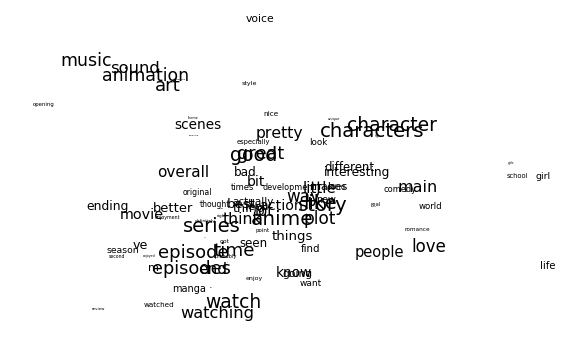

In [702]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

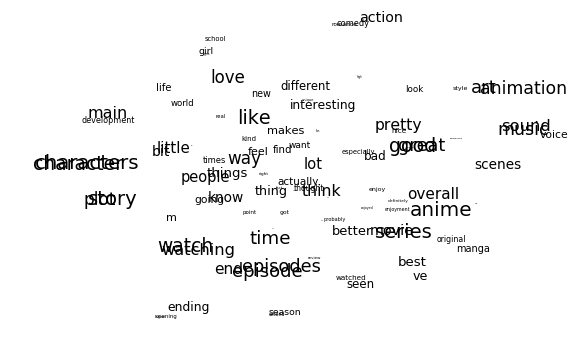

In [703]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [73]:
review_df['review'][:20]

0     Cowboy Bebop is an episodic series. By episodi...
1     Utawarerumono manages to be one of those harem...
2     First, let me say that I\\'m not a fan of boxi...
3     Saiyuki is one of those animes that just grabs...
4     A comedy/romance based on the manga by Rumiko ...
5     What do you say about an anime that is just ab...
6     Kare Kano was a romance anime that could have ...
7     Overall:  My very best anime and i haven't act...
8     Overall:Honestly I really don't care about oth...
9     Hunters… What do you think about when you hear...
10    Bomberman, if you liked the game then you will...
11    Hate watching those anime that drag on for too...
12    Elfen Lied is something else. Just watching th...
13    ===Animation===Toei did a pretty good job with...
14    Love bread?  Ever wondered how they make it?  ...
15    Scrapped Princess is a quite interesting genre...
16    Slayers is a comedy/adventure/fantasy anime di...
17    If you'd like to see my full review than l

In [556]:
keywords = ['scary','blood','killing','ghost','gloomy','dark','darkness','violence','slayers','relaxing','plain','calm','soothing']


In [20]:
review_df['tokenized_words'] = review_df['review'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
review_df['normalized_words'] = review_df['tokenized_words'].apply(lambda x:lucem_illud_2020.normalizeTokens(x,lemma=False))

In [524]:
taggedDocs = []
for index, row in review_df_h.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['overallRating'])
    docKeywords.append(row['workName']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
review_df_h['TaggedAbstracts'] = taggedDocs
reviewD2V = gensim.models.doc2vec.Doc2Vec(review_df_h['TaggedAbstracts'], size = 25)
print(review_df_h['TaggedAbstracts'])

0        ([cowboy, bebop, episodic, series, episodic, m...
1        ([utawarerumono, manages, harem, animes, possi...
2        ([let, i\\'m, fan, boxing, fact, pretty, hate,...
3        ([saiyuki, animes, grabs, episode, wo, let, ep...
4        ([comedy, romance, based, manga, rumiko, takah...
                               ...                        
14995    ([story, story, edward, elric, found, eduard, ...
14996    ([movie, heart, warming, characters, unique, s...
14997    ([clannad, originally, visual, novel, pc, kyot...
14998    ([detail, review, wrote, manga*tamiki, wakiki,...
14999    ([half, movie, extremely, boring, story, time,...
Name: TaggedAbstracts, Length: 15000, dtype: object


In [426]:
reviewD2V.docvecs[1000]

array([ 0.5521214 , -0.34660336, -0.28243974,  1.6916969 ,  0.08458388,
       -0.6048177 , -1.5222051 ,  0.11925302, -0.24933988, -0.2329682 ,
        0.70786196,  1.3571529 , -0.14132737,  2.111212  , -1.4084097 ,
       -1.1868218 ,  1.2899429 ,  1.051305  , -0.02507528,  0.226507  ,
        1.7689136 , -0.15176187,  0.26791826, -0.07456066,  0.2843357 ],
      dtype=float32)

In [527]:
reviewD2V.most_similar(positive = ['japan','world'], negative = ['sakura'], topn = 1)

[('apocalyptic', 0.82994544506073)]

In [530]:
reviewD2V.most_similar(positive = ['horror','movie'], negative = ['ghost'], topn = 1)

[('thrills', 0.7722503542900085)]

In [534]:
reviewD2V.docvecs.most_similar([ reviewD2V['dark'] ], topn=5 )

[('darkness', 0.7192763090133667),
 ('dark', 0.6133599281311035),
 ('scary', 0.5979629755020142),
 ('Gad_Guard', 0.5861226320266724),
 ('Dirty_Pair_no_Ooshoubu__Nolandia_no_Nazo', 0.5706272125244141)]

In [115]:
from IPython.display import Image
reviewD2V.docvecs.most_similar([ reviewD2V.docvecs['Shining_Tears_X_Wind'] ], topn=5 )

[('Shining_Tears_X_Wind', 1.0),
 ('Bleach__The_Sealed_Sword_Frenzy', 0.622992753982544),
 ('Tokineiro', 0.6156351566314697),
 ('Innocent_Venus', 0.6133731603622437),
 ('Dogs__Bullets___Carnage', 0.6005896329879761)]

In [117]:
reviewD2V.docvecs.most_similar([ reviewD2V['magic']+reviewD2V['kid']+reviewD2V['happy']], topn=5 )

[('Osakana_wa_Ami_no_Naka', 0.6739438772201538),
 ('After_The_Animation', 0.588451087474823),
 ('Gakuen_Heaven', 0.5851773023605347),
 ('Shounen_Maid_Kuuro-kun__Tenshi_no_Uta', 0.5711440443992615),
 ('Nyoro-n_Churuya-san', 0.5678746700286865)]

In [136]:
reviewD2V.docvecs.most_similar([ reviewD2V['kill']+reviewD2V['blood']+reviewD2V['red']], topn=5 )

[('Baoh_Raihousha', 0.6991081237792969),
 ('Jigen_Sengokushi__Kuro_no_Shishi_-_Jinnai-hen', 0.6945781707763672),
 ('Grappler_Baki_TV', 0.6269474029541016),
 ('Seikai_no_Senki_II', 0.6165720224380493),
 ('Natural_2__Duo', 0.6151338219642639)]

In [669]:
reviewD2V.most_similar( [ reviewD2V.docvecs['Cowboy_Bebop']+reviewD2V.docvecs['Kino_no_Tabi__The_Beautiful_World'] ], topn=5)

[('tabi', 0.7374928593635559),
 ('kino', 0.7295339107513428),
 ('interwoven', 0.6563735604286194),
 ('paranoia', 0.649248480796814),
 ('mastered', 0.6410422325134277)]

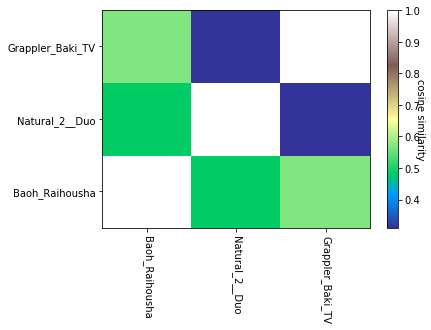

In [139]:
keywords2 = ['Baoh_Raihousha','Natural_2__Duo','Grappler_Baki_TV']
heatmapMatrix = []
for tagOuter in keywords2:
    column = []
    tagVec = reviewD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords2:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, reviewD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords2, minor=False, rotation=270)
a = ax.set_yticklabels(keywords2, minor=False)

In [551]:
targetDocs = review_df_h['workName'][10:30]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = reviewD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, reviewD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

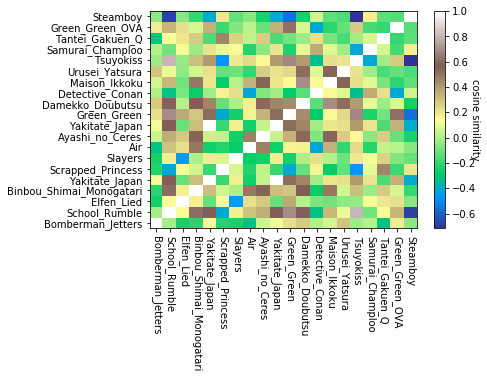

In [552]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)


In [559]:

heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = reviewD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, reviewD2V[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

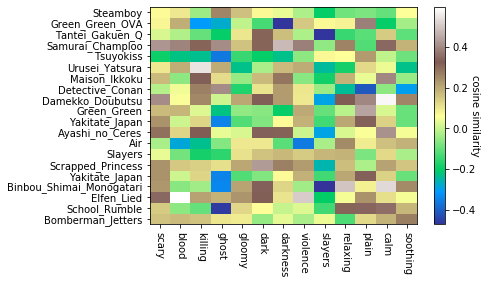

In [560]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [321]:
reviewD2V.save('reviewW2V')

In [325]:
review_df['normalized_words'][:10]

0    [cowboy, bebop, episodic, series, episodic, me...
1    [utawarerumono, manages, harem, animes, possib...
2    [let, i\\'m, fan, boxing, fact, pretty, hate, ...
3    [saiyuki, animes, grabs, episode, wo, let, epi...
4    [comedy, romance, based, manga, rumiko, takaha...
5    [anime, traveler, journeying, different, count...
6    [kare, kano, romance, anime, incredibly, great...
7    [overall, best, anime, actually, seen, level, ...
8    [overall, honestly, care, opinions, anime, fun...
9    [hunters, think, hear, anime, people, killing,...
Name: normalized_words, dtype: object

In [337]:
TargetWords = ['man','him','he', 'woman', 'her', 'she', 'killing','scary','blood','romance', 'funny', 'beautiful','highschool', 'teenager', 'young','office', 'senior', 'old','suspense','ghost','detective','relaxing','reality','police','wine','cowboy','gun','robber']
#words we will be mapping

wordsSubMatrix = []
for word in TargetWords:
    wordsSubMatrix.append(model[word])
wordsSubMatrix = np.array(wordsSubMatrix)

In [338]:
pcaWords = sklearn.decomposition.PCA(n_components = 22).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

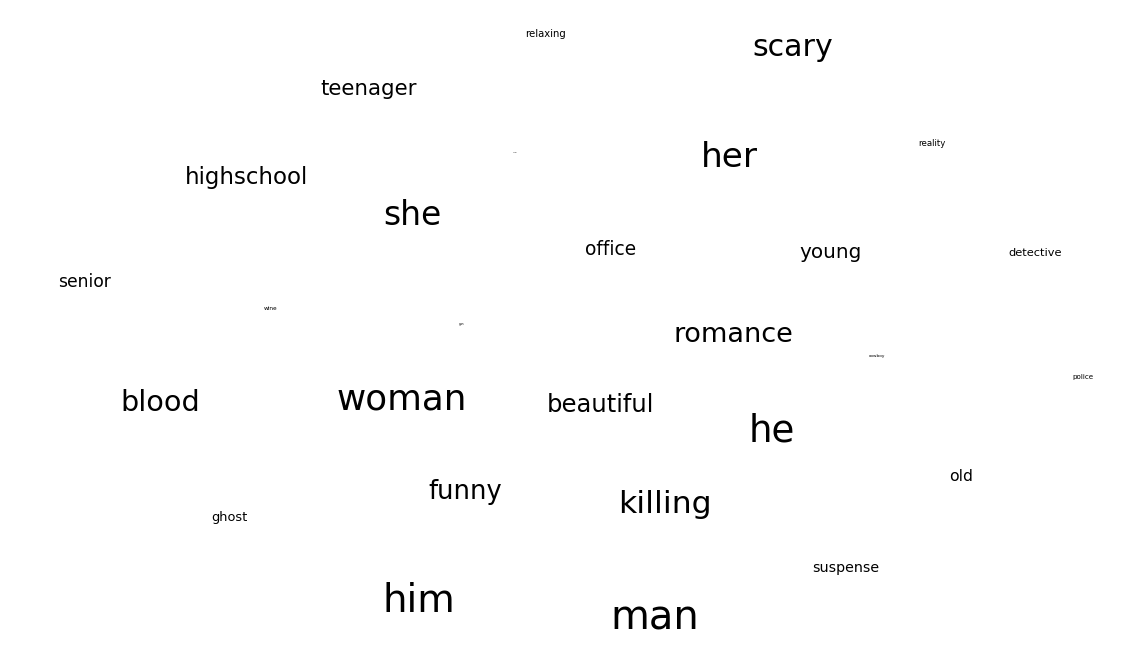

In [339]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(TargetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  40 * (len(TargetWords) - i) / len(TargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [709]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [713]:
Gender = dimension(reviewD2V, ['man'], ['woman'])
Style = dimension(reviewD2V, ['killing','scary','blood','suspense','ghost','gun'], ['romance', 'funny', 'beautiful','relaxing','reality','wine'])
Setting = dimension(reviewD2V, ['highschool', 'class', 'students'], ['office', 'workers', 'seniors'])
Job = dimension(reviewD2V,['detective','police','doctor','teacher'],['cowboy','thief','godfather','boss'])

In [518]:
job = ['detective','police','cowboy','thief','doctor','professor','artist','teacher','worker']
style = ['killing','scary','blood','suspense','ghost','gun','romance', 'funny', 'beautiful','relaxing','reality','violence','dark','gloomy']
setting = ['highschool', 'teenager', 'young','office', 'senior', 'old','university','factory','apartment','building','park','car','museum']
gender  = ['man','woman']

In [714]:
def makeDF(model, word_list):
    g = []
    s = []
    e = []
    j = []
    
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        s.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Style.reshape(1,-1))[0][0])
        e.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Setting.reshape(1,-1))[0][0])
        j.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1),Job.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'setting': e, 'style': s,'job':j}, index = word_list)
    return df


In [715]:
OCCdf = makeDF(reviewD2V, job) 
Styledf = makeDF(reviewD2V, style)
settingdf = makeDF(reviewD2V, setting)

In [716]:
vocab = reviewD2V.wv.index2word

In [717]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

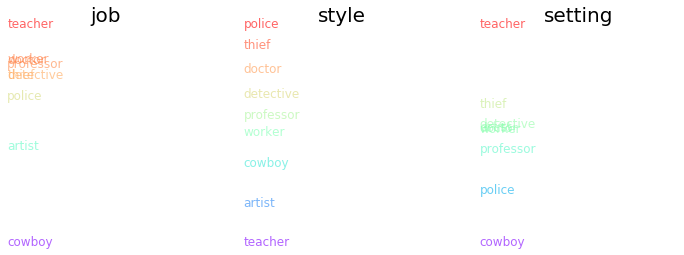

In [719]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'job')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'style')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'setting')
plt.show()

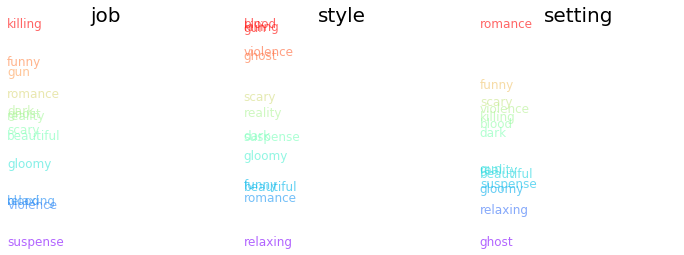

In [720]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Styledf, 'job')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Styledf, 'style')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Styledf, 'setting')
plt.show()

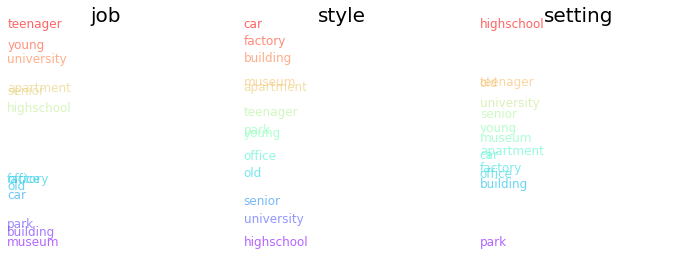

In [721]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, settingdf, 'job')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, settingdf, 'style')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, settingdf, 'setting')
plt.show()

In [18]:
voc = reviewW2V.wv.index2word
voc

['anime',
 'story',
 'characters',
 'series',
 'like',
 'character',
 'good',
 'watch',
 'time',
 'art',
 'episode',
 'episodes',
 'great',
 'plot',
 'way',
 'music',
 'love',
 'animation',
 'watching',
 'main',
 'think',
 'pretty',
 'people',
 'sound',
 'end',
 'little',
 'overall',
 'movie',
 'lot',
 'know',
 've',
 'action',
 'bit',
 'm',
 'best',
 'thing',
 'better',
 'things',
 'scenes',
 'bad',
 'seen',
 'ending',
 'life',
 'actually',
 'interesting',
 'feel',
 'makes',
 'different',
 'going',
 'girl',
 'season',
 'find',
 'new',
 'world',
 'voice',
 'manga',
 'want',
 'look',
 'times',
 'comedy',
 'watched',
 'original',
 'development',
 'review',
 'kind',
 'school',
 'got',
 'thought',
 'probably',
 'point',
 'especially',
 'enjoy',
 'nice',
 'fact',
 'enjoyment',
 'right',
 'second',
 'real',
 'style',
 'far',
 'romance',
 'found',
 'girls',
 'opening',
 'shows',
 'long',
 'enjoyed',
 'high',
 'gets',
 'fan',
 'definitely',
 'funny',
 'unique',
 'looking',
 'fun',
 'amazing',


In [22]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [23]:
W2Vmodel = gensim.models.Word2Vec(review_df['normalized_words'], min_count=0, size=100, hs=1, negative=0) 
review_df['likelihood'] = review_df['normalized_sents'].apply(lambda x: adprob(x, W2Vmodel))
#help(word_vectors)


In [450]:
for ad in review_df.sort_values(by = 'likelihood', ascending = False)['review'][-5:]:
    print (ad + '\n\n')

NOTE: This review is intended to cover Gantz in its entirety.Gantz is about as close as you�ll ever get to a love it or hate it anime. It�s littered with so much gore, profanity, nudity, and sex that it�ll either immediately turn you off or immediately glue your eyes to the screen. Being a person from the latter group I have to say I absolutely loved Gantz right from the start. Well, okay, not exactly right from the start. Gantz starts out in the life of Kei Kurono, an angst ridden teenager who has nothing better to do but think negatively to himself and get                  boners in class. He�s always worrying about something, and doesn�t care about anyone else except for himself. To put it simply, he�s like an emo kid on acid. He complains about everything, but mostly dwells on the fact that he�s never gotten laid. Hmm�wonder why. Ten minutes of listening to this punk whine and cry while so eloquently squeezing in the occasional F-word and I dare anyone to not want to turn this anim

In [566]:
adprob([["lovely", "boy"]], W2Vmodel)

-19.101505

In [567]:
adprob([["lovely", "girl"]], W2Vmodel)

-13.613995

In [189]:
from gensim.models import FastText
model_ted = FastText(review_df_h['normalized_words'], size=100, window=5, min_count=5, workers=4,sg=1)

In [588]:
review_df.groupby(["workName",'peopleFoundUseful','overallRating'])[['likelihood']].mean().sort_values('likelihood', ascending = False)[700:750
                                                                                                                                       ]

,,,likelihood
workName,peopleFoundUseful,overallRating,
Shakugan_no_Shana,7,9,-34.889816
Kareshi_Kanojo_no_Jijou,47,8,-34.925137
Code_Geass__Hangyaku_no_Lelouch,7,7,-34.928329
Kaze_no_Stigma,14,8,-34.930141
Rizelmine,32,6,-34.965286
Kiniro_no_Corda__Primo_Passo_-_Hitonatsu_no_Encore,34,9,-34.990150
Bishoujo_Senshi_Sailor_Moon,17,10,-35.017872
Himesama_Goyoujin,8,5,-35.018826
Time_Bokan,12,7,-35.020397


In [591]:
review_df.groupby(["overallRating",'characterRating','soundRating'])[['likelihood']].mean().sort_values('likelihood', ascending = False)

,,,likelihood
overallRating,characterRating,soundRating,
5,8,6,-16.275427
1,1,3,-23.069838
4,1,6,-24.837862
10,8,6,-25.531723
9,0,9,-25.857782
...,...,...,...
5,3,2,-123.865608
7,4,7,-128.704071
5,3,3,-132.407089


In [590]:
review_df.groupby("author")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
author,
F0RR,-10.036272
HugGaara,-13.768100
kaoru88,-15.424953
BadLuckTuck,-16.552422
Lirima,-17.220730
...,...
SunoharaMaster90,-150.204891
death_oni666,-152.560974
7Th,-152.817764


In [191]:
model_ted.wv.most_similar('robot')

[('robot\\', 0.9498561024665833),
 ('robots', 0.8868048191070557),
 ('robo', 0.8821775913238525),
 ('robotnik', 0.8719408512115479),
 ('robotic', 0.8576734066009521),
 ('robotics', 0.8554517030715942),
 ('robotech', 0.8072638511657715),
 ('giant', 0.7923586368560791),
 ('rob', 0.7885173559188843),
 ('mech', 0.7530350685119629)]

In [248]:
si = word_vectors.wv.most_similar("anime")
si

[('manga', 0.8306878209114075),
 ('live-action', 0.7139478921890259),
 ('ova', 0.6849613189697266),
 ('animated', 0.6658540964126587),
 ('spin-off', 0.6460409164428711),
 ('cartoon', 0.6258808374404907),
 ('adaption', 0.6165875196456909),
 ('comic', 0.6111397743225098),
 ('animation', 0.6100625991821289),
 ('sci-fi', 0.6085641384124756)]

In [24]:
import copy

def calc_syn0norm(model):
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)


    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    
    m = other_vecs.T.dot(base_vecs) 

    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [83]:
review_df['postTime2'] = review_df['postTime'].str.split('-').str.get(0)
review_df['postTime2']
review_df


,id,workId,reviewId,workName,postTime,episodesSeen,author,peopleFoundUseful,overallRating,storyRating,animationRating,soundRating,characterRating,enjoymentRating,review,postTime2,tokenized_sents,normalized_sents
0,8121,1,1,Cowboy_Bebop,2006-11-07 18:34:00,26,Xinil,162,10,8,10,10,10,10,Cowboy Bebop is an episodic series. By episodi...,2006,"[[Cowboy, Bebop, is, an, episodic, series], [B...","[[cowboy, bebop, episodic, series], [episodic,..."
1,63480,856,9,Utawarerumono,2006-11-08 00:24:00,26,Crystal,218,8,8,7,7,9,8,Utawarerumono manages to be one of those harem...,2006,"[[Utawarerumono, manages, to, be, one, of, tho...","[[utawarerumono, manages, harem, animes, possi..."
2,8452,263,10,Hajime_no_Ippo,2006-11-08 14:39:00,76,Xinil,827,10,10,9,9,10,10,"First, let me say that I\\'m not a fan of boxi...",2006,"[[First, let, me, say, that, I\\'m, not, a, fa...","[[let, i\\'m, fan, boxing], [fact, pretty, hat..."
3,66544,129,11,Gensoumaden_Saiyuuki,2006-11-09 05:22:00,50,Chelle,69,9,8,6,7,10,9,Saiyuki is one of those animes that just grabs...,2006,"[[Saiyuki, is, one, of, those, animes, that, j...","[[saiyuki, animes, grabs, episode, wo, let, ep..."
4,55936,210,12,Ranma_½,2006-11-09 16:48:00,161,running_lemon,40,7,6,8,8,8,7,A comedy/romance based on the manga by Rumiko ...,2006,"[[A, comedy, romance, based, on, the, manga, b...","[[comedy, romance, based, manga, rumiko, takah..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,30576,121,31205,Fullmetal_Alchemist,2010-10-08 12:59:00,51,otyme,2,10,9,8,7,10,9,Story:The story is about Edward Elric (I found...,2010,"[[Story], [The, story, is, about, Edward, Elri...","[[story], [story, edward, elric, found, eduard..."
14996,49847,1689,31206,Byousoku_5_Centimeter,2010-10-08 13:25:00,3,kirathesavior,1,8,8,9,9,8,10,this movie was really heart warming. the chara...,2010,"[[this, movie, was, really, heart, warming], [...","[[movie, heart, warming], [characters, unique,..."
14997,33545,2167,31209,Clannad,2010-10-08 16:11:00,23,xm0123,6,10,9,9,10,10,10,Clannad was originally a visual novel for the ...,2010,"[[Clannad, was, originally, a, visual, novel, ...","[[clannad, originally, visual, novel, pc], [ky..."
14998,54369,8525,31214,Kami_nomi_zo_Shiru_Sekai,2010-10-08 20:28:00,1,Sugarsync,6,9,9,8,9,8,9,*this is the detail from the review i wrote in...,2010,"[[this, is, the, detail, from, the, review, i,...","[[detail, review, wrote, manga*tamiki, wakiki,..."


In [77]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [78]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        print(subsetDF)
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

In [84]:
rawEmbeddings, comparedEmbeddings = compareModels(review_df, 'postTime2')
#rawModels(review_df,'postTime2')

        id workId reviewId                           workName  \
0     8121      1        1                       Cowboy_Bebop   
1    63480    856        9                      Utawarerumono   
2     8452    263       10                     Hajime_no_Ippo   
3    66544    129       11               Gensoumaden_Saiyuuki   
4    55936    210       12                            Ranma_½   
5    22039    486       13  Kino_no_Tabi__The_Beautiful_World   
6    68626    145       14            Kareshi_Kanojo_no_Jijou   
7    18797    136       15                    Hunter_x_Hunter   
8    43899    268       16                         Golden_Boy   
9    18796    136       17                    Hunter_x_Hunter   
10  101808    751       18                  Bomberman_Jetters   
11   44952     24       19                      School_Rumble   
12   62242    226       20                         Elfen_Lied   
13  104779   1214       21           Binbou_Shimai_Monogatari   
14   45780     28       2

In [85]:
rawEmbeddings.keys()

dict_keys(['2006', '2007', '2008', '2009', '2010'])

In [86]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

romance


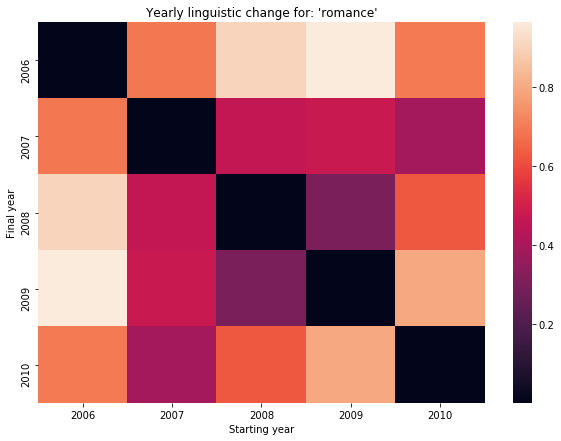

In [87]:
targetWord = 'romance'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

hate


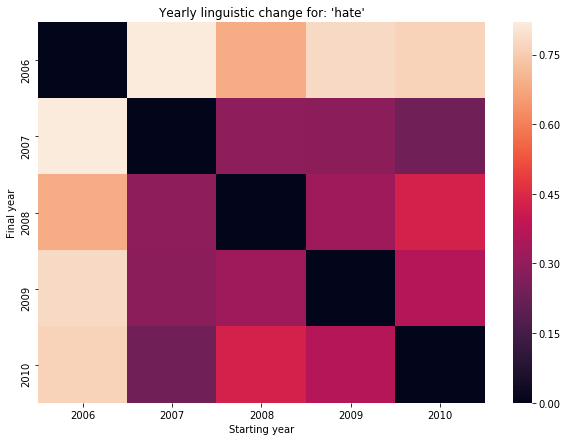

In [92]:
targetWord = 'hate'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()
         

In [93]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [94]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 232 words to compare


In [95]:
wordDivergences[:20]

[('follow', 4.533234171569347),
 ('poor', 4.48951767757535),
 ('easy', 4.267359554767609),
 ('score', 4.2026882683858275),
 ('type', 4.120262373704463),
 ('endings', 4.115860195830464),
 ('occasionally', 4.064325328916311),
 ('starts', 4.038073130650446),
 ('alot', 4.010442974744365),
 ('jin', 3.9889801379758865),
 ('fairly', 3.987789226695895),
 ('special', 3.983005986083299),
 ('harem', 3.9792249986203387),
 ('develop', 3.9766561463475227),
 ('x', 3.972365794237703),
 ('kind', 3.9683358538895845),
 ('enjoyed', 3.902394875884056),
 ('enjoyable', 3.894607152789831),
 ('theme', 3.89224636554718),
 ('goes', 3.8672789566917345)]

In [96]:
wordDivergences[-20:]

[('sound', 2.6862601190805435),
 ('expect', 2.6839626133441925),
 ('samurai', 2.669640690088272),
 ('things', 2.6684865057468414),
 ('leave', 2.6638589799404144),
 ('good', 2.6277555525302887),
 ('time', 2.5542499274015427),
 ('find', 2.5482065677642822),
 ('watch', 2.546863228082657),
 ('story', 2.514767110347748),
 ('bit', 2.498124837875366),
 ('number', 2.4540416598320007),
 ('episode', 2.417812466621399),
 ('stories', 2.4026727080345154),
 ('ranma', 2.401169627904892),
 ('hunter', 2.3584823608398438),
 ('characters', 2.31142121553421),
 ('character', 2.253087967634201),
 ('seen', 1.8597404062747955),
 ('anime', 1.5622852444648743)]

follow


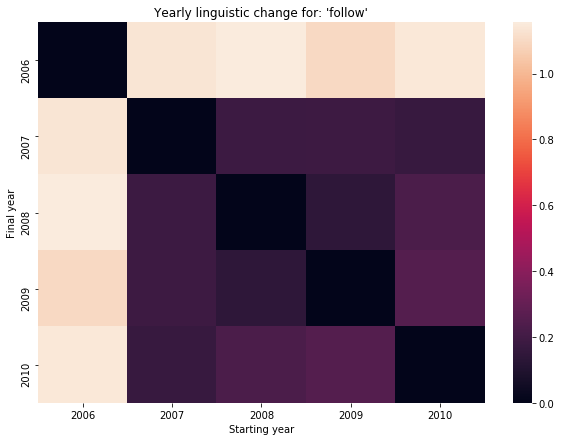

In [97]:

targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

anime


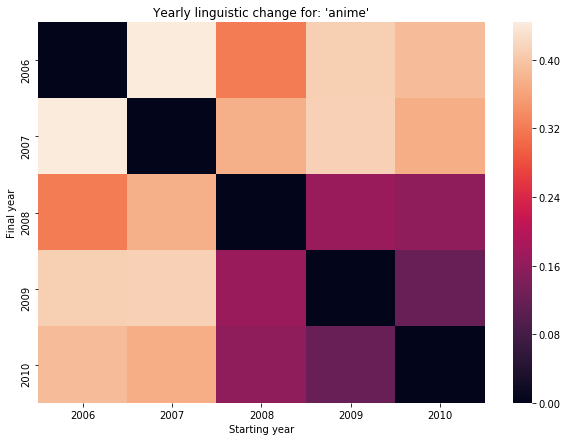

In [98]:

targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [99]:
'''
It reveals that audience still use similar metrics of measurement when they evaluate an animation across these years. And some of their taste remain stable since adjectives like "best","expect" remain stable. But their measurement of evaluation for bad works seem to change
'''

'\nIt reveals that audience still use similar metrics of measurement when they evaluate an animation across these years. And some of their taste remain stable since adjectives like "best","expect" remain stable. But their measurement of evaluation for bad works seem to change\n'

In [592]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences



In [673]:
df_IM = pd.read_csv("/Users/shiyipeng/Downloads/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv")
df_IM = df_IM.iloc[0:15000,:]
df_IM.head

<bound method NDFrame.head of                                                     text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
14995  <br /><br />Summary: Not worth the film<br /><...      0
14996  I got to see this just this last Friday at the...      1
14997  OK, I have watched the original French version...      0
14998  The only reason I know this film exists is bec...      0
14999  Simply put, there are two parts of this series...      1

[15000 rows x 2 columns]>

In [683]:
x_train = df_IM.loc[0:7499,'text'].values
y_train = df_IM.loc[0:7499,'label'].values
x_test = df_IM.loc[7500:15000,'text'].values
y_test = df_IM.loc[7500:15000,'label'].values
tokenize_obj = Tokenizer()
total_review = x_train + x_test
tokenize_obj.fit_on_texts(total_review)

In [684]:
max_length = max([len(s.split())for s in total_review])
vocav_size = len(tokenize_obj.word_index) + 1

In [685]:
x_train_tokens = tokenize_obj.texts_to_sequences(x_train)
x_test_tokens = tokenize_obj.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_tokens,maxlen= max_length, padding='post')
x_test_pad = pad_sequences(x_test_tokens,maxlen= max_length, padding='post')

In [687]:
import keras
from tensorflow.keras import Sequential

from keras.layers import Dense,Embedding,LSTM,GRU
from keras.layers.embeddings import Embedding

Embedding_DIM = 100
model = keras.Sequential()
model.add(Embedding(vocav_size,Embedding_DIM,input_length = max_length))
model.add(GRU(units=32,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss= 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2980, 100)         7234700   
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 7,247,501
Trainable params: 7,247,501
Non-trainable params: 0
_________________________________________________________________


In [688]:
model.fit(x_train_pad,y_train,batch_size=128,validation_data = (x_test_pad,y_test),epochs=25,verbose=2)

Train on 7500 samples, validate on 7500 samples
Epoch 1/25
 - 193s - loss: 0.6941 - accuracy: 0.4972 - val_loss: 0.6933 - val_accuracy: 0.4960
Epoch 2/25
 - 184s - loss: 0.6934 - accuracy: 0.4920 - val_loss: 0.6944 - val_accuracy: 0.4960
Epoch 3/25
 - 197s - loss: 0.6936 - accuracy: 0.5047 - val_loss: 0.6934 - val_accuracy: 0.4960
Epoch 4/25
 - 195s - loss: 0.6933 - accuracy: 0.5011 - val_loss: 0.6936 - val_accuracy: 0.4960
Epoch 5/25
 - 194s - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4960
Epoch 6/25
 - 211s - loss: 0.6935 - accuracy: 0.4989 - val_loss: 0.6935 - val_accuracy: 0.4960
Epoch 7/25
 - 219s - loss: 0.6934 - accuracy: 0.4977 - val_loss: 0.6936 - val_accuracy: 0.4960
Epoch 8/25
 - 200s - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6934 - val_accuracy: 0.4960
Epoch 9/25
 - 181s - loss: 0.6932 - accuracy: 0.5069 - val_loss: 0.6933 - val_accuracy: 0.4960
Epoch 10/25
 - 183s - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6932 - val_accuracy: 0.4960
E

In [646]:
test1 = review_df['review'][200]
test2 = review_df['review'][2]
test3 = review_df['review'][54]
test4 = review_df['review'][98]
test5 = review_df['review'][900]
test6 = review_df['review'][1009]
test_sample = [test1+test2+test3+test4+test5+test6]

In [691]:
test_sample_token = tokenize_obj.texts_to_sequences(test_sample)
test_sample_pad = pad_sequences(test_sample_token,maxlen= max_length)
model.predict(test_sample_pad)

array([[0.49441338]], dtype=float32)

In [670]:
test1

"Where to begin!? One Piece is a very adventurous story. Never in one place for too long the story is full fun and unusual things.One Piece is about a rather childish 17 year old boy (Monkey D. Luffy) who aspires to reach his dreams of becoming Pirate King and keeping the promises he's made.  Meeting many a friend along the way the story progresses through many story arcs that build the personality and integrity of each character.The first friend and crew member he makes is his ever faithful First Mate (Zoro) who also has a dream to achieve.I am not going to explain every                  character. That would take too long and it would spoil some of the fun. The best way to understand this anime is to watch it.One Piece is a really good story, perfect for anyone who likes pirate stories. Though a very long and yet unfinished story thus far, I find it to be very enjoyable. The comedy is some of the best I have seen in any anime.I recommend watching in its original japanese with english

In [692]:
review_df.shape

(5000, 21)

In [694]:
test_loss, test_acc = model.evaluate(x_test_pad, y_test)
print(test_acc)

7500/7500 [==============================] - 74s 10ms/step
0.4959999918937683
